In [1]:
import logging
from braincoder.models import EncodingRegressionModel, GaussianPRF, EncodingModel, RegressionGaussianPRF

import pandas as pd
import numpy as np
from patsy import dmatrix
import matplotlib.pyplot as plt

from braincoder.optimize import ParameterFitter

/Users/gdehol/mambaforge/envs/braincoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

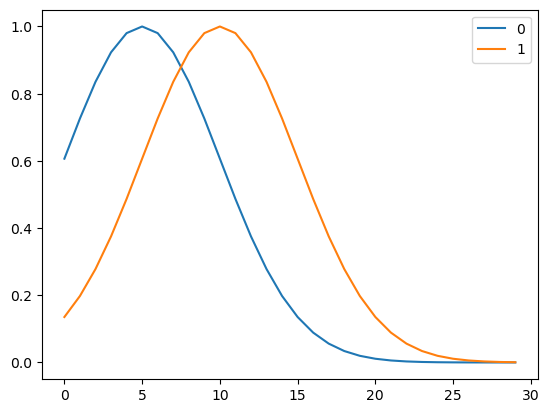

In [2]:
# Model 1 is the narrow condition, which has a receptive field at 15
parameters1 = pd.DataFrame([{'mu':15, 'sd':5, 'amplitude':1, 'baseline':0}])


# Model 2 is the wide condition, which has a receptive field at 
# (mu_wide = 10 + 2* (mu_narrow  - 10)) = 20
parameters2 = parameters1.copy()
parameters2['mu'] = 10 + 2*(parameters2['mu'] - 10)

parameters = pd.concat([parameters1, parameters2])
parameters.index = [0, 1]

model = GaussianPRF(parameters=parameters)

paradigm = pd.DataFrame({'x':np.arange(10, 40)})


pred = model.predict(paradigm)

pred.plot()

# RegressionGaussianPRF-version of same model (only 4 parameters!)

<Axes: xlabel='level_1', ylabel='y0'>

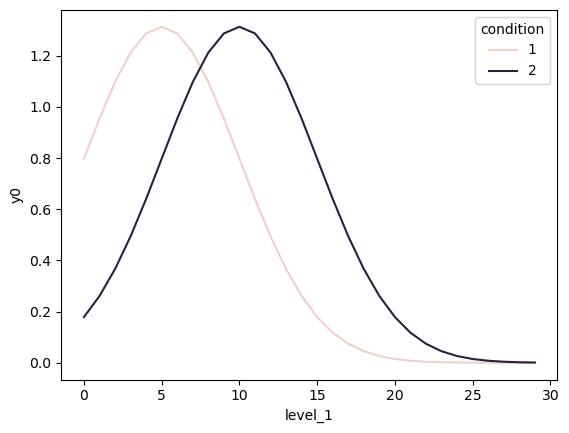

In [3]:
import seaborn as sns
paradigm_regress = paradigm.copy().astype(np.float32)
paradigm_regress = pd.concat([paradigm_regress, paradigm_regress], keys=[1, 2], names=['condition'])
paradigm_regress['condition'] = np.repeat([1, 2], 30)

parameters_regress = pd.DataFrame([{'condition':5, 'sd':5, 'amplitude':1, 'baseline':0}],)

model = RegressionGaussianPRF(paradigm=paradigm_regress,
                              regressors={'mu':'0+condition'},
                              baseline_parameter_values={'mu':10.})


parameters_regress.columns = model.parameter_labels

pred = model.predict(parameters=parameters_regress, paradigm=paradigm_regress)

pred.columns = ['y0']

# pred.plot()

sns.lineplot(data=pred.reset_index(), x='level_1', y='y0', hue='condition')


Working with chunk size of 11111111
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([1, 2, 3, 4, 5, 6, 7, 8, 9]), [1.0], [0.0]] MultiIndex([(       'mu_unbounded', 'condition'),
            (       'sd_unbounded', 'Intercept'),
            ('amplitude_unbounded', 'Intercept'),
            ( 'baseline_unbounded', 'Intercept')],
           names=['parameter', 'regressor'])


100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


parameter,mu_unbounded,sd_unbounded,amplitude_unbounded,baseline_unbounded
regressor,condition,Intercept,Intercept,Intercept
source,,,,
0,5.0,5.0,1.0,0.0


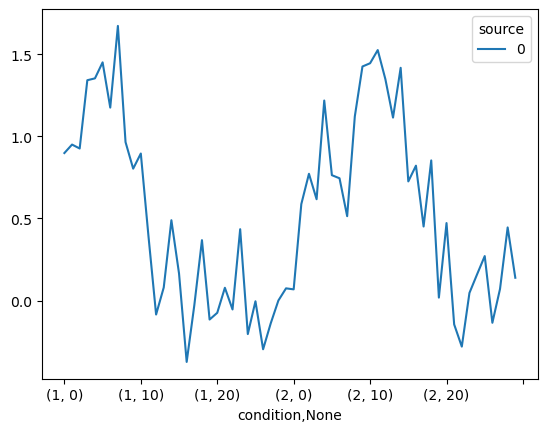

In [7]:
from braincoder.optimize import ParameterFitter


data = model.simulate(paradigm=paradigm_regress, parameters=parameters_regress, noise=0.25)

data.plot()

fitter = ParameterFitter(model, data, paradigm_regress)

mu_condition = np.arange(0, 15) # Max 25
sd = np.arange(1, 10) # Max 10
amplitude = [1.0]
baseline = [0.0]

grid_pars = fitter.fit_grid(mu_condition, sd, amplitude, baseline)

grid_pars

In [8]:
ols_pars = fitter.refine_baseline_and_amplitude(grid_pars)

gd_pars = fitter.fit(init_pars=ols_pars)

gd_pars

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 1


Current R2: 0.79579/Best R2: 0.79579:  14%|█▍        | 144/1000 [00:01<00:09, 92.55it/s] 


parameter,mu_unbounded,sd_unbounded,amplitude_unbounded,baseline_unbounded
regressor,condition,Intercept,Intercept,Intercept
source,,,,
0,5.01849,4.871884,1.054112,0.016657
